In [1]:
import matplotlib
#matplotlib.use('Agg')
%matplotlib tk


%load_ext autoreload
%autoreload 2

#%matplotlib tk
%autosave 180
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import sys
sys.path.append("/home/cat/code/widefield/") # go to parent dir

# 
import numpy as np
import os

import scipy
from statsmodels.stats.multitest import multipletests

import pandas as pd
from scipy import stats
import matplotlib.patches as mpatches


# 
from tqdm import tqdm, trange

#  SVM module
from svm.svm import PredictSVMChoiceSuperSession


Autosaving every 180 seconds


<ipython-input-1-18c431622d4a>:12: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [21]:
def get_data_pie_charts(n_sec_lockout,
                        body_feats_lockout,
                        animal_id,
                        root_dir):
    
    # skip 1,2,3 n-sec-lockouts and the empty lockouts
    if len(body_feats_lockout)==0:    # if not using any lockout window
        if n_sec_lockout in [1,2, 3]:  # 
            return [], [], []


    # 
    fname = os.path.join(root_dir,
                         animal_id,
                         'super_sessions',
                         'alldata_body_and_nonreward_lockout_'+str(n_sec_lockout)+'secLockout_'+
                         str(body_feats_lockout)+'bodyfeats.npz')

    # 
    data = np.load(fname, allow_pickle=True)

    trials = data['trials']
    
    # 
    behaviors = data['behaviors']
    # 
    names = data['names']

    
    return trials, names, behaviors


# 
def get_no_of_hours(root_dir,
                    animal_id):
    
    
    sessions = os.listdir(os.path.join(root_dir,
                           animal_id,
                           'tif_files'))
    
    # 
    n_sessions=0
    n_rewarded=0
    for session in sessions:
        fname = os.path.join(root_dir,
                            animal_id,
                            'tif_files',
                            session,
                            'rewarded_times.txt')
        
        if os.path.exists(fname):
            n_sessions+=1

            temp = np.loadtxt(fname, dtype='float32', ndmin=1)
            if temp.shape[0]>0:
                n_rewarded+=temp.shape[0]

            
    return n_sessions, n_rewarded

# 
def filter_trace(trace, smooth_window=30):

    box = np.ones(smooth_window)/smooth_window
    trace_smooth = np.convolve(trace, box, mode='valid')

    return trace_smooth


# 
def compute_significance(data):

    #
    significance = 0.05

    #
    sig = []
    for k in range(data.shape[0]):

        #
        res = scipy.stats.ttest_1samp(data[k], 0.5)

        sig.append(res[1])


    sig_save = np.array(sig).copy()

    # multiple hypothesis test Benjamini-Hockberg
    temp = np.array(sig)
    temp2 = multipletests(temp, 
                          alpha=significance, 
                          method='fdr_bh')
    sig = temp2[1]

    # find earliest significant;
    edt = 0
    for k in range(sig.shape[0]-1,0,-1):
        if sig[k]<=significance:
            edt = k+1
        else:
            break

    # 
    edtsec = -(sig.shape[0]-edt)/30.

    # 
    return edtsec


def box_plots(edts,
             licking_flag=False):
    
    pvals = [0.05,0.01,0.001,0.0001,0.00001]

    clrs_local = ['magenta','brown','pink','lightblue','darkblue', 'blue']
    
    # 
    if licking_flag==False:
        my_dict = dict(three = edts[0][1], 
                   six = edts[1][1],
                   nine = edts[2][1],
                   twelve = edts[3][1],
                   fifteen = edts[4][1],                      
                  #All = edts[5]+15,                      
                 )
    else:
        my_dict = dict(one = edts[0][1], 
               two = edts[1][1],
               three = edts[2][1],
               six = edts[3][1],
               #nine = edts[4][1],
               #twelve = edts[3][1],
               #fifteen = edts[4][1],                      
              #All = edts[5]+15,                      
             )
        
    cmap = plt.cm.get_cmap('Reds', len(my_dict))    # 11 discrete colors

        
    #
    data = pd.DataFrame.from_dict(my_dict, orient='index')
    data = data.transpose()

    print ("DATA: ", data.shape)
    print ("means: ", np.mean(data,0))
    means =np.mean(data,0)
    ######################################################### 
    ################## SCATTER PLOTS ########################
    ######################################################### 
    for i,d in enumerate(data):
        y = data[d]
        x = np.random.normal(i+1, 0.04, len(y))
        #print (x)
        #print (y)
        if licking_flag==False:
            plt.scatter(x,y,
                   c=clrs_local[i],
                   #c=cmap(i),
                    s=100,
                   edgecolor='black')
        else:
            plt.scatter(x,y,
                   #c=clrs_local[i],
                   c=cmap(i),
                    s=100,
                   edgecolor='black')

    ######################################################### 
    ###################### BOX PLOTS ########################
    ######################################################### 
    flierprops = dict(#marker='o', 
                      #markerfacecolor='g', 
                      markersize=10000,
                      linestyle='none', 
                      markeredgecolor='r')

    #
    data.boxplot(showfliers=False,
                 flierprops=flierprops)


    
    #
    plt.xlim(0.5, 6.5)
    plt.ylim(-15,0)    
    plt.xticks([])
    plt.yticks([])

    #
    plt.plot([0,6.5], [-3,-3],'--',linewidth=3,c='grey',alpha=.5)
    plt.plot([0,6.5], [-5,-5],'--',linewidth=3,c='grey',alpha=.5)
    plt.plot([0,6.5],[-10,-10],'--',linewidth=3,c='grey',alpha=.5)

    # ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

    patches = []
    for p in range(1,len(my_dict),1):
        res = stats.ks_2samp(edts[p][1], edts[0][1])
        print ("res: ", res)
        label_ = ''
        for k in range(len(pvals)):
            if res[1]<pvals[k]:
                label_ = label_ + "*"
            else:
                break

        patches.append(mpatches.Patch(label=label_))

    plt.legend(handles=patches,fontsize=12)

    return means




def box_plots_6animals(edts,
             licking_flag=False):
    
    pvals = [0.05,0.01,0.001,0.0001,0.00001]

    clrs_local = ['magenta','brown','pink','lightblue','darkblue', 'blue']
    
    # 
    if licking_flag==False:
        my_dict = dict(
                   M1 = edts[0][1], 
                   M2 = edts[1][1],
                   M3 = edts[2][1],
                   M4 = edts[3][1],
                   M5 = edts[4][1],                      
                   M6 = edts[5][1],                      
                  #All = edts[5]+15,                      
                 )

        
    cmap = plt.cm.get_cmap('Reds', len(my_dict))    # 11 discrete colors

        
    #
    data = pd.DataFrame.from_dict(my_dict, orient='index')
    data = data.transpose()

    print ("DATA: ", data.shape)
    print ("means: ", np.mean(data,0))
    means =np.mean(data,0)
    ######################################################### 
    ################## SCATTER PLOTS ########################
    ######################################################### 
    for i,d in enumerate(data):
        y = data[d]
        x = np.random.normal(i+1, 0.04, len(y))
        #print (x)
        #print (y)
        if licking_flag==False:
            plt.scatter(x,y,
                   c=clrs_local[i],
                   #c=cmap(i),
                    s=100,
                   edgecolor='black')
        else:
            plt.scatter(x,y,
                   #c=clrs_local[i],
                   c=cmap(i),
                    s=100,
                   edgecolor='black')

    ######################################################### 
    ###################### BOX PLOTS ########################
    ######################################################### 
    flierprops = dict(#marker='o', 
                      #markerfacecolor='g', 
                      markersize=10000,
                      linestyle='none', 
                      markeredgecolor='r')

    #
    data.boxplot(showfliers=False,
                 flierprops=flierprops)


    
    #
    plt.xlim(0.5, 6.5)
    plt.ylim(-15,0)    
    plt.xticks([])
    plt.yticks([])

    #
    plt.plot([0,6.5], [-3,-3],'--',linewidth=3,c='grey',alpha=.5)
    plt.plot([0,6.5], [-5,-5],'--',linewidth=3,c='grey',alpha=.5)
    plt.plot([0,6.5],[-10,-10],'--',linewidth=3,c='grey',alpha=.5)

    # ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

    patches = []
    for p in range(1,len(my_dict),1):
        res = stats.ks_2samp(edts[p][1], edts[0][1])
        print ("res: ", res)
        label_ = ''
        for k in range(len(pvals)):
            if res[1]<pvals[k]:
                label_ = label_ + "*"
            else:
                break

        patches.append(mpatches.Patch(label=label_))

    plt.legend(handles=patches,fontsize=12)

    return means

100%|██████████| 13/13 [00:01<00:00,  8.25it/s]
/media/cat/4TBSSD/anaconda3/envs/wide/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
100%|██████████| 13/13 [00:02<00:00,  6.12it/s]
/media/cat/4TBSSD/anaconda3/envs/wide/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
100%|██████████| 13/13 [00:01<00:00,  6.77it/s]
/media/cat/4

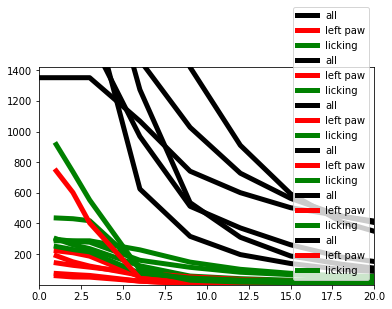

In [4]:
################################################################################
######### Compute # of rewqarded lever pulls vs. locked out behavior ###########
################################################################################

# Generate data for Fig 6e - revision manuscript (Fig 6e is plotted in the next cell)

# this function is for making rewarded/unrewarded times and generating the final data+label .npz files
root_dir = '/media/cat/4TBSSD/yuki/'

#
animal_ids = ['IA1','IA2','IA3','IJ1','IJ2','AQ2']
#animal_ids = ['IA1']

#
n_sec_lockouts = [0,1,2,3,6,9,12,15,18,21,24,27,30]
#n_sec_lockouts = [2]

#
body_feats_lockouts = [[],[0],[1],[5],[0,1,5]]
body_feats_lockouts = [[],[0],[5]]
#body_feats_lockouts = [[]]

#labels = ['all', 'left paw','right paw','licking',' left paw, right paw and licking']
labels = ['all', 'left paw', 'licking']

clrs = ['black','red','green']

#
fig=plt.figure()
ctr2 = 0
all_array = []
for k in range(len(animal_ids)):
    all_array.append([])
    #left_array.append([])
    #lick_array.append([])


fname_all_array = '/home/cat/all_array.npy'

for ctr_animal, animal_id in enumerate(animal_ids):

    
    # 
    ax=plt.subplot(1,1,1)
    
    # 
    ctr=0
    
    rewarded_array = []
    nSec_array = []
    
    fname_rewarded = '/home/cat/rewarded_array_'+animal_id+'.npy'
    fname_nSec = '/home/cat/nSec_array_'+animal_id+'.npy'
    ctr3 = 0
    for body_feats_lockout in body_feats_lockouts:
        
        rewarded = []
        nSec = []
        #trials_array.append([])
        #names_array.append([])
        for n_sec in tqdm(n_sec_lockouts):
            if len(body_feats_lockout)>0:
                if n_sec==0:
                    continue

            # 
            trials, names, _ = get_data_pie_charts(n_sec,
                                                    body_feats_lockout,
                                                    animal_id,
                                                    root_dir)
           
            # 
            n_rew = 0       # reset rewarded and nonrewarded plots
            n_nonrew = 0

            # 
            if len(trials)>0:
                for k in range(len(trials)):
                    n_rew += trials[k].shape[0]

                if n_sec==0:
                    n_sec=3

                
                rewarded.append(n_rew)
                nSec.append(n_sec)

        #        
        rewarded_array.append(rewarded)
        nSec_array.append(nSec)
        
                
        if nSec[0]==3:
            ntemp_rew = []
            ntemp_sec = []
            for k in range(3):
                ntemp_rew.append(rewarded[0])
                ntemp_sec.append(k)
                
            ntemp_sec.append(nSec)
            ntemp_rew.append(rewarded)

            nSec = np.hstack(ntemp_sec)
            rewarded = np.hstack(ntemp_rew)
            
        rewarded = np.hstack(rewarded)
        #rewarded = rewarded/1351
        plt.plot(nSec,
                 rewarded, 
                 c=clrs[ctr],
                 label=labels[ctr],
                linewidth=5)
        
        all_array[ctr_animal].append(rewarded)
        
        ctr+=1
        
        ctr3+=1

    np.save(fname_rewarded, rewarded_array)
    np.save(fname_nSec, nSec_array)
    
    plt.legend()
    #plt.semilogy()    
    #plt.scatter(n_sec, n_nonrew)
    plt.xlim(0,20)
    plt.ylim(bottom=0.01)
    ctr2+=1
    
    if False:
        plt.savefig('/home/cat/decays.svg')
        plt.close()
        break
    else:
        
        pass
    
np.save(fname_all_array, all_array)
plt.show()


No handles with labels found to put in legend.


[[array([1351, 1351, 1351, 1351, 1068,  741,  601,  503,  449,  399,  356,
        339,  311]), array([190, 150, 122,  62,  31,  19,  12,   8,   7,   7,   4,   3]), array([300, 261, 236, 124,  57,  40,  30,  25,  23,  19,  16,  13])], [array([1704, 1704, 1704, 1704, 1466, 1027,  728,  564,  449,  385,  329,
        289,  249]), array([59, 51, 50, 24,  7,  3,  1,  1]), array([287, 287, 287, 228, 148, 101,  75,  59,  53,  49,  45,  40])], [array([2447, 2447, 2447, 2447, 1273,  536,  310,  188,  135,   96,   68,
         51,   44]), array([222, 209, 187,  52,   9,   3,   1]), array([436, 431, 418, 118,  36,  15,   7,   5,   5,   5,   5,   4])], [array([1615, 1615, 1615, 1615,  968,  512,  371,  261,  182,  137,  119,
         99,   85]), array([143, 127, 115,  77,  52,  35,  24,  16,  14,  13,  11,   9]), array([297, 284, 278, 160, 114,  82,  66,  49,  41,  38,  34,  29])], [array([1867, 1867, 1867, 1867,  625,  316,  197,  139,  100,   82,   70,
         55,   51]), array([74, 67, 61, 24

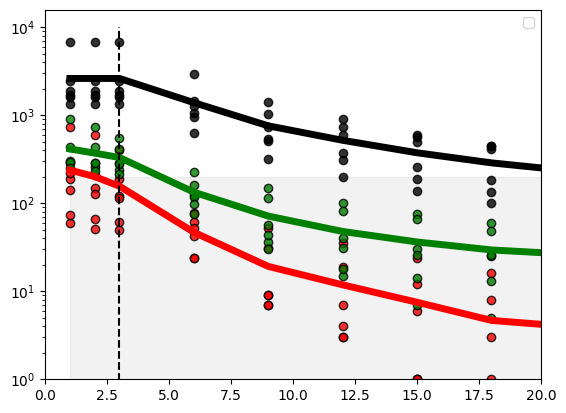

In [8]:
########################################################
######## PLOT # LEVER PULLS VS LOCKOUTS - FIG 6E #######
########################################################

# plot figure 6e - revision manuscript
fig=plt.figure()

print (all_array)

clrs = ['black','red','green']
#####################################
rew_all = []
for k in range(6):
    temp = all_array[k][0]
    #temp = temp/np.max(temp)
    rew_all.append(temp)

rew_all = np.vstack(rew_all)
rew_all = rew_all[:,1:]
x = np.array([1,2,3,6,9,12,15,18,21,24,27,30])

#
if False:
    mean = np.mean(rew_all, axis=0)
    std = np.std(rew_all, axis=0)    
    plt.plot(x,
             mean,
             color=clrs[0],
             linewidth=5)

    plt.fill_between(x, mean+std, mean-std, 
                     color=clrs[0], alpha=.1)
else:
    mean = np.mean(rew_all, axis=0)
    std = np.std(rew_all, axis=0)    
    plt.plot(x,
             mean,
             color=clrs[0],
             linewidth=5)
    for p in range(6):
        plt.scatter(x,rew_all[p],
                   c=clrs[0],
                    edgecolor='black',
                   alpha=.8)
    
# ######################################################
x = np.array([1,2,3,6,9,12,15,18,21,24,27,30])

rew_all = []
for k in range(6):
    temp = np.zeros(x.shape[0])
    temp2 = all_array[k][1]
    #temp2 = temp2/np.max(temp2)
    print (temp2.shape)
    temp[:temp2.shape[0]]=temp2
    
    rew_all.append(temp)

rew_all = np.vstack(rew_all)

#
if False:
    mean = np.mean(rew_all, axis=0)
    std = np.std(rew_all, axis=0)    
    plt.plot(x,
         mean,
             color=clrs[1],
         linewidth=5)

    plt.fill_between(x, mean+std, mean-std, 
                     color=clrs[1], alpha=.1)
else:
    mean = np.mean(rew_all, axis=0)
    std = np.std(rew_all, axis=0)    
    plt.plot(x,
         mean,
             color=clrs[1],
         linewidth=5)
    for p in range(6):
        plt.scatter(x,rew_all[p],
                   c=clrs[1],
                    edgecolor='black',
                   alpha=.8)
    
# ######################################################
x = np.array([1,2,3,6,9,12,15,18,21,24,27,30])

rew_all = []
for k in range(6):
    temp = np.zeros(x.shape[0])
    temp2 = all_array[k][2]
    #temp2 = temp2/np.max(temp2)
    print (temp2.shape)
    temp[:temp2.shape[0]]=temp2
    
    rew_all.append(temp)

rew_all = np.vstack(rew_all)

#
if False:
    mean = np.mean(rew_all, axis=0)
    std = np.std(rew_all, axis=0)    
    plt.plot(x,
         mean,
             color=clrs[2],
         linewidth=5)

    plt.fill_between(x, mean+std, mean-std, 
                     color=clrs[2], alpha=.1)
else:
    mean = np.mean(rew_all, axis=0)
    std = np.std(rew_all, axis=0)    
    plt.plot(x,
         mean,
             color=clrs[2],
         linewidth=5)
    
    for p in range(6):
        plt.scatter(x,rew_all[p],
                   c=clrs[2],
                    edgecolor='black',
                   alpha=.8)
    
#
plt.plot([3,3],[0,10000],'--',c='black')
plt.semilogy()
plt.fill_between(x, np.zeros(x.shape[0]), np.zeros(x.shape[0])+200,
                     color='black', alpha=.05)
plt.xlim(0,20)
#plt.ylim(bottom=1)

plt.legend()
plt.ylim(bottom=1)
plt.show()
#plt.savefig('/home/cat/decays_all.svg')
#plt.close()

        
        

<ipython-input-2-a1a2827547ed>:55: UserWarning: loadtxt: Empty input file: "/media/cat/4TBSSD/yuki/IA1/tif_files/IA1pm_Apr22_Week2_30Hz/rewarded_times.txt"
  temp = np.loadtxt(fname, dtype='float32', ndmin=1)
<ipython-input-2-a1a2827547ed>:55: UserWarning: loadtxt: Empty input file: "/media/cat/4TBSSD/yuki/IA1/tif_files/IA1am_May2_Week4_30Hz/rewarded_times.txt"
  temp = np.loadtxt(fname, dtype='float32', ndmin=1)
<ipython-input-2-a1a2827547ed>:55: UserWarning: loadtxt: Empty input file: "/media/cat/4TBSSD/yuki/IA2/tif_files/IA2pm_Feb15_30Hz/rewarded_times.txt"
  temp = np.loadtxt(fname, dtype='float32', ndmin=1)
<ipython-input-2-a1a2827547ed>:55: UserWarning: loadtxt: Empty input file: "/media/cat/4TBSSD/yuki/IA2/tif_files/IA2am_Mar10_30Hz/rewarded_times.txt"
  temp = np.loadtxt(fname, dtype='float32', ndmin=1)
<ipython-input-2-a1a2827547ed>:55: UserWarning: loadtxt: Empty input file: "/media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2am_Dec9_30Hz/rewarded_times.txt"
  temp = np.loadtxt(fname, d

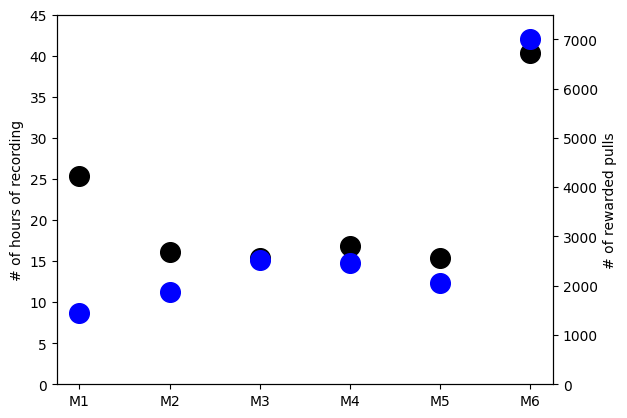

In [9]:
###################################################
##### VISUALIZE # OF HRS OF RECORDING - FIG 6A ####
###################################################

# generate fig 6a - revision manuscript

#
animal_ids = ['IA1','IA2','IA3','IJ1','IJ2','AQ2']
animal_names = ['M1','M2','M3','M4','M5','M6']

# 
fig=plt.figure()
ax1=plt.subplot(111)
ax2 = ax1.twinx()

hrs_array = []
rew_array = []
for ctr, animal_id in enumerate(animal_ids):
    n_hrs, n_rew = get_no_of_hours(root_dir,animal_id)
    
    hrs_array.append(n_hrs)
    rew_array.append(n_rew)
    
    n_hrs = n_hrs*22/60.
    
    ax1.scatter(ctr, n_hrs, c='black',
                s=200,
                label=animal_id)
    
    ax2.scatter(ctr, n_rew, c='blue',
                s=200,
                label=animal_id)
np.save('/home/cat/hrs_array.npy',hrs_array)    
np.save('/home/cat/rew_array.npy',rew_array)
    
# 
ax1.set_ylabel("# of hours of recording")
ax2.set_ylabel("# of rewarded pulls")
plt.xticks(np.arange(6), animal_names)
ax1.set_ylim(0,45)
ax2.set_ylim(0,7500)

# 
if False:
    plt.savefig('/home/cat/n_hours.svg')
    plt.close()
else:
    plt.show()

(9,)
['rewarded_lever_pulls' 'unrewarded_lever_pulls' 'left_paw' 'right_paw'
 'nose' 'jaw' 'right_ear' 'tongue' 'lever_DLC']
[ 2430  3798  4980  5230  8028  8685  9445  9933 10248 10570 11278 11751
 12455 13304 14266 14746 15768 16534 17282 18079 18509 18829 19497 19883
 20090 20578 22000 22349 23371 23721 23889 24091 24424 24942 25114 25664
 30035 30889 32193 33042 33376 33950 34499 35239 35713 35925 36410 37101
 37302 37789 38446] [  -63   -41     8 ... 40004 40006 40010]


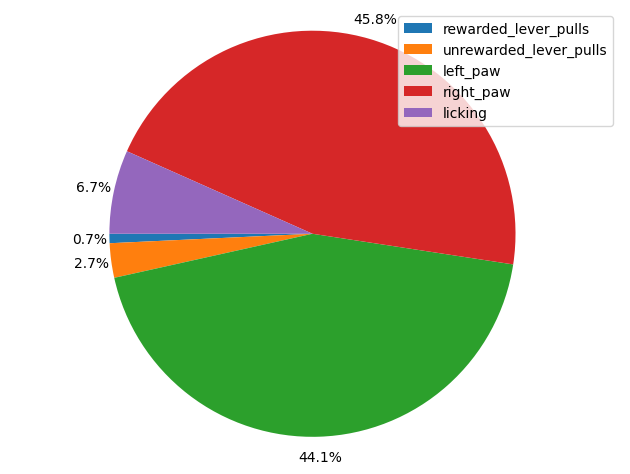

In [13]:
# ################################################
# ##### VISUALIZE PIE CHARTS - SINGLE ANIMAL ####
# ################################################

fname = '/media/cat/4TBSSD/yuki/IA1/tif_files/IA1pm_Feb9_30Hz/IA1pm_Feb9_30Hz_body_and_nonreward_lockout_0secLockout_[]bodyfeats.npz'
d = np.load(fname, allow_pickle=True)
trials = d['trials']
random = d['random']
behaviors = d['behaviors']
names = d['names']

print (behaviors.shape)
print (names)
print (behaviors[0], behaviors[3])

selected_behaviors = [0,1,2,3,7]

sizes = []
for k in selected_behaviors:
    sizes.append(behaviors[k].shape[0])

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = names[selected_behaviors]
labels[-1]='licking'

# 
fig1, ax1 = plt.subplots()
patches, texts,_ = ax1.pie(sizes, 
                        #explode=explode, 
                        #labels=labels, 
                        autopct='%1.1f%%',
                        #shadow=True, 
                        pctdistance=1.1,
                        labeldistance=1.2,
                        startangle=180
                       )
plt.legend(patches, labels, loc="best")

# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.tight_layout()

# 
plt.show()



In [10]:
#########################################################
##### VISUALIZE PIE CHARTS - ALL SESSIONS - FIG 3b ######
#########################################################
#
animal_id = 'AQ2'    # 
animal_ids = ['IA1','IA2','IA3','IJ1','IJ2','AQ2']
#animal_ids = ['IA1']
all_rewarded = []
plotting=False
for animal_id in animal_ids:

    # 
    n_sec = 0

    #
    body_feats_lockout = []

    ctr=0

    # 
    trials, names, behaviors = get_data_pie_charts(n_sec,
                                                   body_feats_lockout,
                                                   animal_id,
                                                   root_dir)

    # 
    sess = 3
    feat = 1
    print (np.vstack(trials).shape)
    print ("# sessions: ", len(behaviors))
    print ("seesion ",sess, " # of behav ", len(behaviors[sess]))
    print ("# of feature moves: ", behaviors[sess][feat].shape)


    # get # rewarded pulls:
    n_rew = 0
    n_nonrew = 0
    n_left_paw = 0
    n_right_paw = 0
    n_licking = 0

    # 
    feat_rew = 0
    feat_nonrew = 1
    feat_left_paw = 2
    feat_right_paw = 3
    feat_licking = 7

    n_sess = 0
    min_quiescence = 30 # in frame times
    for sess in trange(len(behaviors)):
        try:
            if len(behaviors[sess][feat_left_paw])>0:
                n_rew+= behaviors[sess][feat_rew].shape[0]
                n_nonrew+= behaviors[sess][feat_nonrew].shape[0]

                # left paw
                temp = behaviors[sess][feat_left_paw]
                diff = temp[1:]-temp[:-1]
                #print (diff)
                idx = np.where(diff>=min_quiescence)[0]
                n_left_paw+= idx.shape[0]

                # left paw
                temp = behaviors[sess][feat_right_paw]
                diff = temp[1:]-temp[:-1]
                idx = np.where(diff>=min_quiescence)[0]
                n_right_paw+= idx.shape[0]

                # left paw
                temp = behaviors[sess][feat_licking]
                diff = temp[1:]-temp[:-1]
                idx = np.where(diff>=min_quiescence)[0]
                n_licking+= idx.shape[0]
            n_sess+=1

        except:
            pass

    print ("video sessions: ", n_sess)
    print ("nrew: ", n_rew)  
    print ("n_nonrew: ", n_nonrew)  
    print ("left_paw: ", n_left_paw)  
    print ("n_right_paw: ", n_right_paw)  
    print ("n_licking: ", n_licking)  


    sizes = np.array([n_rew, n_nonrew, n_left_paw, n_right_paw, n_licking])
    sizes = sizes/np.sum(sizes)*100

    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    labels = ['rewarded lever pulls','non-rewarded lever pulls','left paw','right paw', 'licking']

    # 
    all_rewarded.append(sizes[0])
    
    # 
    if plotting:

        fig1, ax1 = plt.subplots()
        colors = ['blue','lightgrey','wheat','paleturquoise','pink']
        patches, texts,_ = ax1.pie(sizes, 
                                #explode=explode, 
                                #labels=labels, 
                                colors=colors,
                                autopct='%1.1f%%',
                                #shadow=True, 
                                pctdistance=1.1,
                                labeldistance=1.2,
                                startangle=180,
                                textprops={'fontsize': 20}
                               )

        #patches[0][0].set_alpha(.1)

        labels = [f'{l}, {s:0.1f}%' for l, s in zip(labels, sizes)]

        ax1.legend(patches, labels, loc="best")

        # Set aspect ratio to be equal so that pie is drawn as a circle.
        ax1.axis('equal')
        plt.tight_layout()
        plt.title(animal_id)
        # 

        if False:
            plt.savefig('/home/cat/piechart_'+animal_id+'.svg')
            plt.close()
            break
        else:
            plt.show()
            break

#
np.save('/home/cat/all_rewarded_percentages.npy', all_rewarded)

100%|██████████| 53/53 [00:00<00:00, 12934.08it/s]

(1351, 1800, 16)
# sessions:  53
seesion  3  # of behav  9
# of feature moves:  (35,)
video sessions:  53
nrew:  619
n_nonrew:  2318
left_paw:  6438
n_right_paw:  6703
n_licking:  4471



100%|██████████| 33/33 [00:00<00:00, 18169.08it/s]

(1704, 1800, 16)
# sessions:  33
seesion  3  # of behav  9
# of feature moves:  (9,)
video sessions:  33
nrew:  294
n_nonrew:  537
left_paw:  1567
n_right_paw:  1746
n_licking:  0



100%|██████████| 41/41 [00:00<00:00, 20771.41it/s]

(2447, 1800, 16)
# sessions:  41
seesion  3  # of behav  8
# of feature moves:  (357,)
video sessions:  41
nrew:  524
n_nonrew:  1750
left_paw:  2962
n_right_paw:  2910
n_licking:  1817



100%|██████████| 40/40 [00:00<00:00, 15479.99it/s]

(1615, 1800, 16)
# sessions:  40
seesion  3  # of behav  8
# of feature moves:  (165,)
video sessions:  40
nrew:  376
n_nonrew:  1159
left_paw:  2225
n_right_paw:  2311
n_licking:  1187



100%|██████████| 39/39 [00:00<00:00, 24624.09it/s]

(1867, 1800, 16)
# sessions:  39
seesion  3  # of behav  8
# of feature moves:  (366,)
video sessions:  39
nrew:  354
n_nonrew:  2230
left_paw:  2622
n_right_paw:  2439
n_licking:  1225



100%|██████████| 79/79 [00:00<00:00, 22832.83it/s]

(6739, 1800, 16)
# sessions:  79
seesion  3  # of behav  8
# of feature moves:  (82,)
video sessions:  78
nrew:  2726
n_nonrew:  6982
left_paw:  10746
n_right_paw:  11327
n_licking:  9120


[3.012312034648888, 7.094594594594595, 5.259460002007428, 5.180490493248828, 3.9909808342728295, 6.664873719468961]
5.200451946373588


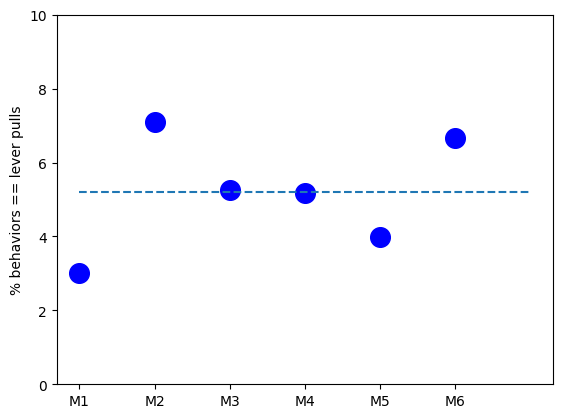

In [14]:
#####################################################
##### VISUALIZE % REWARDED LEVER PULLS - FIG 6c #####
#####################################################

# generate figu 6c revision manuscript

# 
animal_ids = ['IA1','IA2','IA3','IJ1','IJ2','AQ2']
animal_names = ['M1','M2','M3','M4','M5','M6']

# 
fig=plt.figure()
ax1=plt.subplot(111)
for ctr, animal_id in enumerate(animal_ids):
    n_hrs = all_rewarded[ctr]
    ax1.scatter(ctr, n_hrs, c='blue',
                s=200,
                label=animal_id)
       
# 
plt.plot([0,6],[np.mean(all_rewarded),np.mean(all_rewarded)],'--')
ax1.set_ylabel("% behaviors == lever pulls")
plt.xticks(np.arange(6), animal_names)
ax1.set_ylim(0,10)
#ax2.set_ylim(0,7500)

# 
if False:
    plt.savefig('/home/cat/percent_leverpulls.svg')
    plt.close()
else:
    plt.show()
    
    
print (all_rewarded)

print (np.mean(all_rewarded))


# Next - do the SVM decoding plots ###


In [19]:
##########################################
##########################################
##########################################

# generate figure ...

root_dir = '/media/cat/4TBSSD/yuki'

# lockouts = [0,3,6,9,12,15,18,21,24,27,30]
lockouts = [0,1,2,3,6,9,12,15,18,21,24,27,30]
bodyfeats = []


#body_feats_lockouts = [[],[0],[1],[5],[0,1,5]]
#body_feats_lockouts = [[],[0],[5]]
bodyfeats = [5]


# from matplotlib import 
cmap = plt.cm.get_cmap('viridis', len(lockouts))    # 11 discrete colors

#
fig = plt.figure()
animal_ids = ['IA1','IA2','IA3','IJ1','IJ2','AQ2']

# 
for animal_id in animal_ids:
    edts = []
    for ctr, lockout in enumerate(lockouts):

        edts_local=[]
        for n in trange(0, 10000, 50):

            fname = os.path.join(root_dir,
                                 animal_id,
                                 'super_sessions',
                                 'alldata_body_and_nonreward_lockout_'+str(lockout)+'secLockout_'+
                                 str(bodyfeats)+'bodyfeats_'+
                                 str(n)+'_super_res.npz')
            
            #
            try:
                data = np.load(fname,
                          allow_pickle=True)
            except:
                print ("Fname not found: ", animal_id, lockout, bodyfeats)
                break

            acc = data['accuracy']

            # 
            acc2 = []
            for k in range(acc.shape[1]):
                acc2.append(filter_trace(acc[:,k]))

            acc2 = np.vstack(acc2).T

            #
            edt = compute_significance(acc2)
            edts_local.append(edt)

            #break
        if len(edts_local)>0:
            edts.append([lockout,edts_local])

    np.save('/home/cat/'+animal_id+"_edts_lockedout_licking.npy", edts)
#box_plots(edts_local)
#plt.xlim(-30,1)
#plt.ylim(0.4,1.0)
#plt.plot([-30,1],[0.5,0.5],'--',c='grey')
plt.show()

  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IA1 0 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IA1 1 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IA1 2 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IA1 3 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IA1 6 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IA1 9 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IA1 12 [5]


  0%|          | 0/200 [00:00<?, ?it/s]
/media/cat/4TBSSD/anaconda3/envs/wide/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IA1 15 [5]
Fname not found:  IA1 18 [5]
Fname not found:  IA1 21 [5]
Fname not found:  IA1 24 [5]
Fname not found:  IA1 27 [5]
Fname not found:  IA1 30 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IA2 0 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IA2 1 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IA2 2 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IA2 3 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IA2 6 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IA2 9 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IA2 12 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IA2 15 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IA2 18 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IA2 21 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IA2 24 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IA2 27 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IA2 30 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IA3 0 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IA3 1 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IA3 2 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IA3 3 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IA3 6 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IA3 9 [5]
Fname not found:  IA3 12 [5]
Fname not found:  IA3 15 [5]
Fname not found:  IA3 18 [5]
Fname not found:  IA3 21 [5]
Fname not found:  IA3 24 [5]
Fname not found:  IA3 27 [5]
Fname not found:  IA3 30 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IJ1 0 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IJ1 1 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IJ1 2 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IJ1 3 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IJ1 6 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IJ1 9 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IJ1 12 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IJ1 15 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IJ1 18 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IJ1 21 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IJ1 24 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IJ1 27 [5]
Fname not found:  IJ1 30 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IJ2 0 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IJ2 1 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IJ2 2 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IJ2 3 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IJ2 6 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IJ2 9 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  IJ2 12 [5]
Fname not found:  IJ2 15 [5]
Fname not found:  IJ2 18 [5]
Fname not found:  IJ2 21 [5]
Fname not found:  IJ2 24 [5]
Fname not found:  IJ2 27 [5]
Fname not found:  IJ2 30 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  AQ2 0 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  AQ2 1 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  AQ2 2 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  AQ2 3 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  AQ2 6 [5]


  0%|          | 0/200 [00:00<?, ?it/s]

Fname not found:  AQ2 9 [5]
Fname not found:  AQ2 12 [5]
Fname not found:  AQ2 15 [5]
Fname not found:  AQ2 18 [5]
Fname not found:  AQ2 21 [5]
Fname not found:  AQ2 24 [5]
Fname not found:  AQ2 27 [5]
Fname not found:  AQ2 30 [5]


<Figure size 640x480 with 0 Axes>

In [4]:
##########################################################
########## FIG 6G - lockout distributions ################
##########################################################

# generate figure 6g - revision manuscript
#
animal_ids = ['IA1','IA2','IA3','IJ1','IJ2','AQ2']
#animal_ids = ['IA1']#,'IA2','IA3','IJ1','IJ2','AQ2']
licking_flag = False
means = []
for animal_id in animal_ids:
    if licking_flag==False:
        edts = np.load(os.path.join('/home/cat/',
                                animal_id +
                                #'_edts_lockedout_licking.npy'), allow_pickle=True)
                                '_edts_lockedout.npy'), allow_pickle=True)
    else:
        edts = np.load(os.path.join('/home/cat/',
                                animal_id +
                                '_edts_lockedout_licking.npy'), allow_pickle=True)
                                #'_edts_lockedout.npy'), allow_pickle=True)

        
    #
    fig = plt.figure(figsize=(4.5,5.5))
    plt.title(animal_id)
    m_ = box_plots(edts, licking_flag)
    means.append(m_)
    if False:
        plt.savefig(os.path.join('/home/cat/',
                                animal_id+"_edts_lockdout_licking.svg"))
        plt.close()
    else:
        plt.show()

DATA:  (27, 5)
means:  three     -2.855556
six       -2.685714
nine      -1.991111
twelve    -2.430556
fifteen   -1.926667
dtype: float64
res:  KstestResult(statistic=0.164021164021164, pvalue=0.8517362612151119)
res:  KstestResult(statistic=0.3851851851851852, pvalue=0.08664813231587754)
res:  KstestResult(statistic=0.21296296296296297, pvalue=0.7798023139544679)
res:  KstestResult(statistic=0.3925925925925926, pvalue=0.15668362096582977)
DATA:  (34, 5)
means:  three     -4.010784
six       -4.790805
nine      -5.105000
twelve    -4.826190
fifteen   -3.139394
dtype: float64
res:  KstestResult(statistic=0.3022312373225152, pvalue=0.0890159924437578)
res:  KstestResult(statistic=0.14411764705882352, pvalue=0.9165595995181188)
res:  KstestResult(statistic=0.2815126050420168, pvalue=0.3435155245384486)
res:  KstestResult(statistic=0.35294117647058826, pvalue=0.18153108549860508)
DATA:  (49, 5)
means:  three     -5.181633
six       -6.209333
nine      -3.530303
twelve    -3.672222
fifteen 

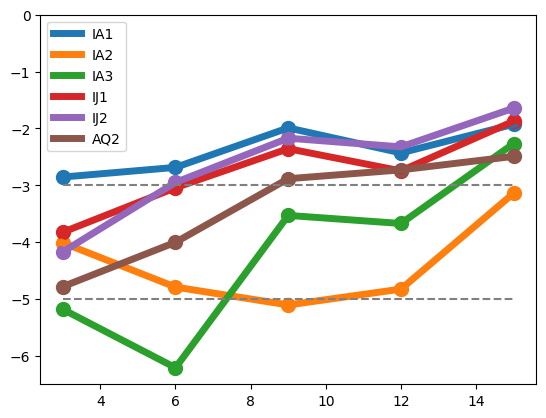

In [24]:
##################################
############## FIG 6H ############
##################################

# generate fig 6h revision manuscript

fig=plt.figure()
t = np.array([3,6,9,12,15])
for k in range(6):
    mm = means[k]#.to_numpy()
    #print (mm)
    plt.plot(t, mm, 
             label=animal_ids[k],
             linewidth=5)
    plt.scatter(t, mm,
               s=100)
    
    
plt.plot([3,15],[-3,-3],'--',c='grey')
plt.plot([3,15],[-5,-5],'--',c='grey')

plt.ylim(-6.5,0)
plt.legend()
if False:
    plt.savefig('/home/cat/mean_fits.svg')
    plt.close()
else:
    plt.show()

In [ ]:
##########################################################
######### Fig 6I - Filtered lockout distributions ########
##########################################################

# generate figure 6i - revision manuscript
  
# 
animal_ids = ['IA1','IA2','IA3','IJ1','IJ2','AQ2']
#animal_ids = ['IA1']#,'IA2','IA3','IJ1','IJ2','AQ2']
means = []
for animal_id in animal_ids:
    edts = np.load(os.path.join('/home/cat/',
                            animal_id +
                            #'_edts_lockedout_licking.npy'), allow_pickle=True)
                            '_edts_lockedout.npy'), allow_pickle=True)
        
    #
    fig = plt.figure(figsize=(4.5,5.5))
    plt.title(animal_id)
    m_ = box_plots(edts, licking_flag)
    means.append(m_)
    if False:
        plt.savefig(os.path.join('/home/cat/',
                                animal_id+"_edts_lockdout_licking.svg"))
        plt.close()
    else:
        plt.show()

DATA:  (27, 6)
means:  M1   -2.855556
M2   -2.685714
M3   -1.991111
M4   -2.430556
M5   -1.926667
M6   -2.007407
dtype: float64
res:  KstestResult(statistic=0.164021164021164, pvalue=0.8517362612151119)
res:  KstestResult(statistic=0.3851851851851852, pvalue=0.08664813231587754)
res:  KstestResult(statistic=0.21296296296296297, pvalue=0.7798023139544679)
res:  KstestResult(statistic=0.3925925925925926, pvalue=0.15668362096582977)
res:  KstestResult(statistic=0.3333333333333333, pvalue=0.4072205047455326)
DATA:  (34, 6)
means:  M1   -4.010784
M2   -4.790805
M3   -5.105000
M4   -4.826190
M5   -3.139394
M6   -2.766667
dtype: float64
res:  KstestResult(statistic=0.3022312373225152, pvalue=0.0890159924437578)
res:  KstestResult(statistic=0.14411764705882352, pvalue=0.9165595995181188)
res:  KstestResult(statistic=0.2815126050420168, pvalue=0.3435155245384486)
res:  KstestResult(statistic=0.35294117647058826, pvalue=0.18153108549860508)
res:  KstestResult(statistic=0.37254901960784315, pvalu

In [24]:
##########################################################
########## FIG 2g - lockout distributions for 15 sec################
##########################################################

# generate figure 6g - revision manuscript
#
animal_ids = ['IA1','IA2','IA3','IJ1','IJ2','AQ2']
#animal_ids = ['IA1']#,'IA2','IA3','IJ1','IJ2','AQ2']
means = []
edts_array = []
for animal_id in animal_ids:
    edts = np.load(os.path.join('/home/cat/',
                                animal_id +
                                '_edts_lockedout.npy'), allow_pickle=True)
                                #'_edts_lockedout.npy'), allow_pickle=True)

    print (edts[4])    
    edts_array.append(edts[4])
    
# #
fig = plt.figure(figsize=(4.5,5.5))
#plt.title(animal_id)
m_ = box_plots_6animals(edts_array, licking_flag)
plt.xlim(0.5,6.5)
if True:
    plt.savefig(os.path.join('/home/cat/',
                            animal_id+"_edts_lockdout_licking.svg"))
    plt.close()
else:
    plt.show()

        

[15
 list([-3.6666666666666665, -3.1, -2.6, -2.6, -1.7666666666666666, -1.9, -1.4333333333333333, -1.3, -0.5333333333333333, -0.36666666666666664])]
[15
 list([-4.466666666666667, -3.7333333333333334, -3.6666666666666665, -2.3666666666666667, -2.6666666666666665, -2.3, -2.0, -4.166666666666667, -4.4, -3.7333333333333334, -1.0333333333333334])]
[15
 list([-2.7, -2.8666666666666667, -2.966666666666667, -0.5333333333333333])]
[15
 list([-0.7666666666666667, -2.6666666666666665, -2.6666666666666665, -2.433333333333333, -0.8333333333333334])]
[15 list([-2.6666666666666665, -0.7333333333333333, -1.5333333333333334])]
[15
 list([-3.4, -2.8, -3.433333333333333, -2.7666666666666666, -2.3666666666666667, -5.266666666666667, -2.3, -2.066666666666667, -1.5333333333333334, -2.0, -0.9666666666666667, -1.0])]
DATA:  (12, 6)
means:  M1   -1.926667
M2   -3.139394
M3   -2.266667
M4   -1.873333
M5   -1.644444
M6   -2.491667
dtype: float64
res:  KstestResult(statistic=0.509090909090909, pvalue=0.106096689

In [12]:


fname = '/media/cat/4TBSSD/yuki/IA3/first_decoding_time.npz'

edts = np.load(fname)['all_res_continuous']+15
print ("edts: ", edts)


edts:  [ -2.36666667  -6.          -4.23333333  -3.83333333  -4.16666667
  -3.3         -4.83333333  -6.4         -4.96666667  -2.23333333
  -3.          -4.43333333  -2.46666667  -3.73333333  -3.66666667
  -3.6         -6.73333333  -1.8         -2.46666667  -3.96666667
  -4.23333333  -2.03333333  -3.16666667  -2.73333333  -4.3
  -5.63333333  -8.93333333  -8.96666667  -5.53333333 -10.5
  -4.66666667  -5.4         -7.76666667  -8.06666667  -2.23333333
  -7.1         -4.56666667  -6.5       ]


In [17]:
data = np.load('/home/cat/AQ2_edts_lockedout.npy',allow_pickle=True)
print (data[2])

[9
 list([-4.533333333333333, -4.9, -3.3333333333333335, -3.3, -1.0666666666666667, -3.6333333333333333, -4.166666666666667, -2.7, -1.4, -2.7333333333333334, -3.6, -2.466666666666667, -2.966666666666667, -2.7666666666666666, -2.966666666666667, -2.7333333333333334, -2.2, -2.2, -3.066666666666667, -2.1, -3.3333333333333335, -2.7333333333333334, -3.3, -3.1, -3.0, -3.6, -2.2666666666666666, -0.6])]
